# MNIST Classification
Inspired by https://www.kaggle.com/ashwani07/mnist-classification-using-random-forest

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt  #Graphics
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
#To show graphs within the notebook
%matplotlib inline 

## Download Dataset

In [2]:
mnist_file = 'mnist.csv'
mnist_file_path = Path(mnist_file)
if not mnist_file_path.is_file():
    # file exists
    print('Dataset does not exist. Downloading...')
    csv_url = 'https://raw.githubusercontent.com/MSc-in-Data-Science/class_material/master/semester_1/Machine_Learning/datasets/digit_recognizer_dataset.csv'
    req = requests.get(csv_url)
    url_content = req.content
    csv_file = open('mnist.csv', 'wb')
    csv_file.write(url_content)
    csv_file.close()
    print('Dataset Downloaded')
else:
    print('Dataset exists')

Dataset exists


In [3]:
#load the datasets
train = pd.read_csv("mnist.csv").astype('int32')
print ("Training dataset has %i observations and %i variables" %(train.shape[0], train.shape[1]-1))

Training dataset has 42000 observations and 784 variables


In [4]:
#check few rows
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#Seperate the target and independant variables
df_x=train.iloc[:,1:]
df_y=train.iloc[:,0]

In [6]:
def print_image(row, df):
    temp=df.iloc[row,:].values
    temp = temp.reshape(28,28).astype('uint8')
    plt.imshow(temp)

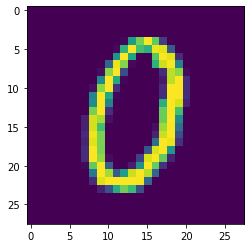

In [7]:
print_image(5, df_x)

d:\pycharmprojects\machine_learning_master_2020\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

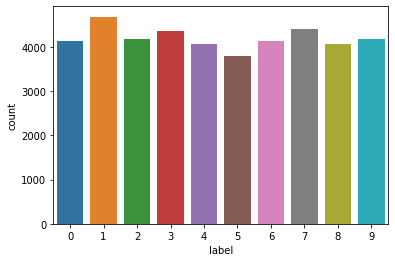

In [8]:
#Check the frequency of each number
sns.countplot(df_y)
df_y.value_counts().sort_index()

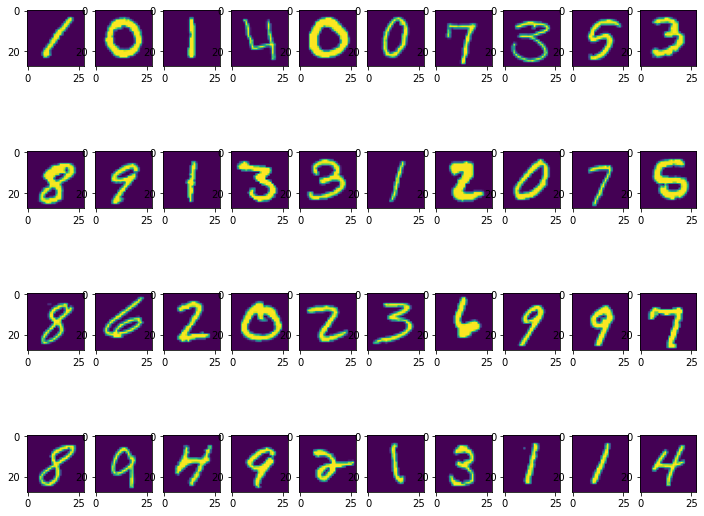

In [9]:
# Print some of the digits/images to inspect the dataset
plt.figure(figsize=(12,10))
for i in range(40):
    plt.subplot(4, 10, i+1)
    print_image(i, df_x)

In [10]:
#Split the dataset

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)

(29400, 784)
(12600, 784)


In [11]:
def general_classification_report(target_test, pred):
    """
    General Classification Report
    :param target_test: target test data
    :param pred: the prediction of the classifier
    """
    print ("Classification Report")
    print(classification_report(target_test, pred))
    print ("Confusion Report")
    print(confusion_matrix(y_test, pred))
    cmrforest = confusion_matrix(target_test , pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cmrforest ,annot=True , fmt = 'd')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title('Confusion Report')

def perform_classification_with_grid_search(clf_name, data_train, data_test, target_train, target_test, cv=10):
    """
    Function that uses several classifiers with parameter tuning
    :param clf_name: Classifier name, can be Random Forest, SVM, kNN, Logistic Regression
    :param data_train: train data
    :param data_test: test data
    :param target_train: target train data
    :param target_test: target test data
    :param cv: number of folds
    :return: A dictionary with the best parameters
    """
    if clf_name=='Random Forest':
        param_grid = {
            'n_estimators': [200],
            'max_features': ['auto'],
            'max_depth' : [4,5,6,7,8],
            'criterion' :['gini', 'entropy']
        }
        clf = RandomForestClassifier(random_state=42)

    elif clf_name=='SVM':
        param_grid = {
            'kernel': ['rbf'],
            'gamma': [1e-3, 1e-4],
            'C': [1, 10, 100, 1000]
            }
        clf = svm.SVC()

    elif clf_name=='kNN':
        param_grid = {'n_neighbors': range(1, 31)}
        clf = KNeighborsClassifier()

    elif clf_name=='Logistic Regression':
        param_grid = {"C": np.logspace(-3,3,7),
                      "penalty": ["l1","l2"]}
        clf = LogisticRegression()

    else:
        print('Provide one of the available classifiers: Random Forest, SVM, kNN, Logistic Regression')
        return

    cv_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv)
    cv_rfc.fit(data_train, target_train)
     # Viewing The Best Parameters
    print('Best Parameters: ', cv_rfc.best_params_)
    print('Best Accuracy Score Achieved in Grid Search: ', cv_rfc.best_score_)
    best_estimator = cv_rfc.best_estimator_
    # Predicting using the best estimator
    best_estimator.fit(data_train, target_train)
    pred=best_estimator.predict(data_test)
    general_classification_report(target_test, pred)
    best_estimator.score(data_test, target_test)

def perform_classification(clf_name, data_train, data_test, target_train, target_test):
    """
    Function that uses several classifiers
    :param clf_name: Classifier name, can be Random Forest, SVM rbf, SVM linear, kNN, Logistic Regression
    :param data_train: train data
    :param data_test: test data
    :param target_train: target train data
    :param target_test: target test data
    """
    if clf_name=='Random Forest':
        clf=RandomForestClassifier(n_estimators=100)

    elif clf_name=='SVM rbf':
        clf = svm.SVC(kernel='rbf')

    elif clf_name=='kNN':
        clf = KNeighborsClassifier()

    elif clf_name=='Logistic Regression':
        clf = LogisticRegression()

    else:
        print('Provide one of the available classifiers: Random Forest, SVM, kNN, Logistic Regression')
        return

    clf.fit(data_train, target_train)
    pred=clf.predict(data_test)
    general_classification_report(target_test, pred)
    clf.score(data_test, target_test)

### PCA

In [12]:
# feature extraction
# n_components=100
scaler = MinMaxScaler()
X_train_rescaled = scaler.fit_transform(X_train)
pca = PCA(n_components = 0.95)
pca.fit(X_train)

# fig, ax = plt.subplots()

# plt.xlim(0.0,800.0)
# plt.ylim(0.0,1.1)

# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# ax.plot(np.cumsum(pca.explained_variance_ratio_), color='b')
# ax.axhline(y=0.95, color='r', linestyle='dotted')
# ax.text(100, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)


X_train_new = pca.transform(X_train)
X_test_new = pca.transform(X_test)
print(X_train_new.shape)
print(X_test_new.shape)

(29400, 153)
(12600, 153)


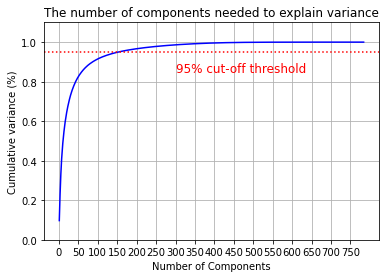

In [13]:
scaler = MinMaxScaler()
scaler.fit_transform(X_train)
pca = PCA().fit(X_train_rescaled)

# plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 785, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 785, step=50)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='dotted')
plt.text(300, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)

ax.grid()
plt.show()

### Classification

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1242
           1       0.98      0.97      0.98      1429
           2       0.93      0.95      0.94      1276
           3       0.92      0.91      0.92      1298
           4       0.95      0.94      0.94      1236
           5       0.92      0.93      0.93      1119
           6       0.95      0.97      0.96      1243
           7       0.95      0.94      0.95      1334
           8       0.92      0.90      0.91      1204
           9       0.92      0.91      0.92      1219

    accuracy                           0.94     12600
   macro avg       0.94      0.94      0.94     12600
weighted avg       0.94      0.94      0.94     12600

Confusion Report
[[1204    0    3    5    2    2   18    0    6    2]
 [   1 1393   13    5    0    2    9    0    6    0]
 [   8    2 1209   15    6    2    1   10   22    1]
 [   2    3   20 1186    0   29    3   12  

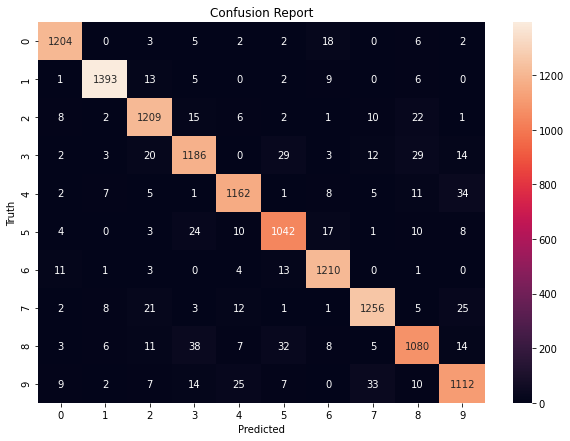

In [14]:
perform_classification('Random Forest', X_train_new, X_test_new, y_train, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1242
           1       0.96      0.99      0.98      1429
           2       0.98      0.96      0.97      1276
           3       0.96      0.97      0.96      1298
           4       0.98      0.96      0.97      1236
           5       0.96      0.96      0.96      1119
           6       0.97      0.99      0.98      1243
           7       0.96      0.97      0.96      1334
           8       0.99      0.92      0.95      1204
           9       0.94      0.95      0.95      1219

    accuracy                           0.97     12600
   macro avg       0.97      0.97      0.97     12600
weighted avg       0.97      0.97      0.97     12600

Confusion Report
[[1232    0    3    0    0    2    5    0    0    0]
 [   0 1417    5    1    0    0    4    1    1    0]
 [  11   12 1228    4    0    2    1   16    1    1]
 [   1    1    3 1254    0   12    1   11  

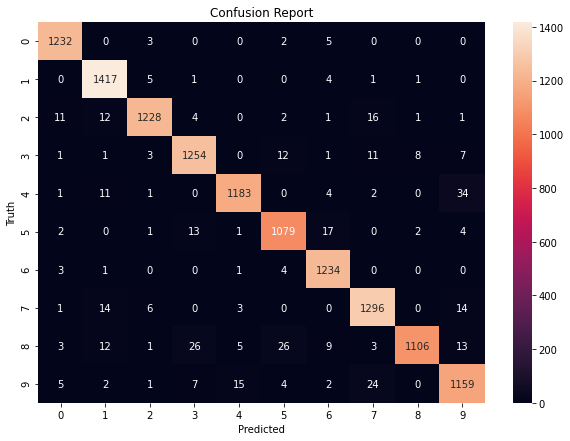

In [15]:
perform_classification('kNN', X_train_new, X_test_new, y_train, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1242
           1       0.99      0.99      0.99      1429
           2       0.97      0.98      0.98      1276
           3       0.98      0.97      0.97      1298
           4       0.98      0.97      0.98      1236
           5       0.97      0.98      0.98      1119
           6       0.98      0.99      0.99      1243
           7       0.98      0.97      0.97      1334
           8       0.97      0.98      0.97      1204
           9       0.96      0.97      0.97      1219

    accuracy                           0.98     12600
   macro avg       0.98      0.98      0.98     12600
weighted avg       0.98      0.98      0.98     12600

Confusion Report
[[1231    0    2    0    2    1    3    0    3    0]
 [   0 1412    5    4    1    0    1    1    5    0]
 [   2    0 1251    2    0    1    0   10    9    1]
 [   1    1    9 1253    1   13    0    4  

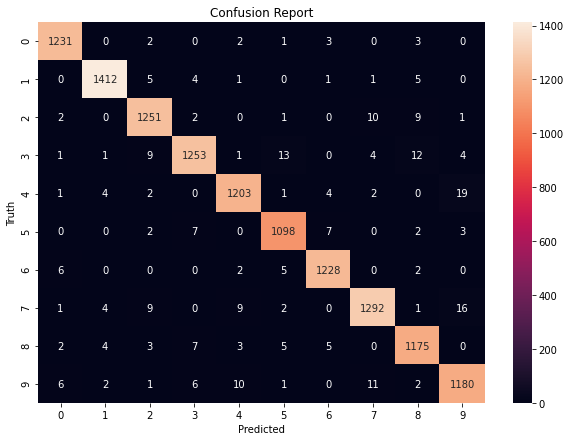

In [16]:
perform_classification('SVM rbf', X_train_new, X_test_new, y_train, y_test)

d:\pycharmprojects\machine_learning_master_2020\venv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1242
           1       0.94      0.97      0.95      1429
           2       0.94      0.90      0.92      1276
           3       0.91      0.90      0.90      1298
           4       0.91      0.93      0.92      1236
           5       0.89      0.86      0.87      1119
           6       0.92      0.96      0.94      1243
           7       0.94      0.93      0.93      1334
           8       0.90      0.84      0.87      1204
           9       0.88      0.89      0.88      1219

    accuracy                           0.92     12600
   macro avg       0.91      0.91      0.91     12600
weighted avg       0.92      0.92      0.92     12600

Confusion Report
[[1198    0    3    2    1    9   21    2    5    1]
 [   0 1389    3    9    1    7    5    1   13    1]
 [  12   16 1152   15   17    7   16   15   17    9]
 [   8    9   26 1162    0   32   10   12  

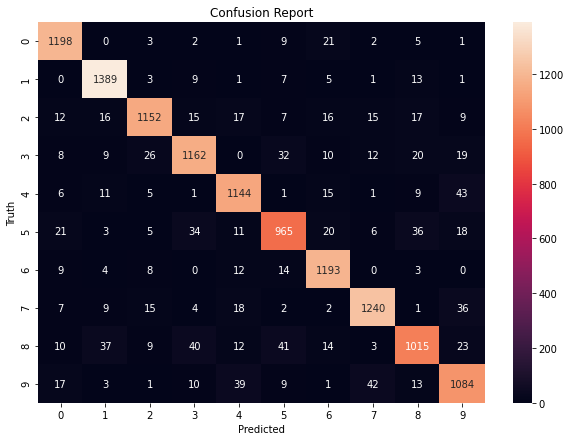

In [17]:
perform_classification('Logistic Regression', X_train_new, X_test_new, y_train, y_test)

### Classification with grid search

In [18]:
# perform_classification_with_grid_search('Random Forest', X_train_new, X_test_new, y_train, y_test)
# perform_classification_with_grid_search('kNN', X_train_new, X_test_new, y_train, y_test)
# perform_classification_with_grid_search('SVM', X_train_new, X_test_new, y_train, y_test)
# perform_classification_with_grid_search('Logistic Regression', X_train_new, X_test_new, y_train, y_test)

### Feature Selection

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1242
           1       0.98      0.98      0.98      1429
           2       0.94      0.95      0.95      1276
           3       0.95      0.92      0.93      1298
           4       0.91      0.86      0.89      1236
           5       0.92      0.94      0.93      1119
           6       0.94      0.98      0.96      1243
           7       0.96      0.94      0.95      1334
           8       0.93      0.94      0.93      1204
           9       0.86      0.89      0.88      1219

    accuracy                           0.94     12600
   macro avg       0.94      0.94      0.94     12600
weighted avg       0.94      0.94      0.94     12600

Confusion Report
[[1203    0    2    1    2    3   14    1   13    3]
 [   0 1395   11    9    2    2    5    1    4    0]
 [   5    1 1217    8    4    6   13   13    9    0]
 [   2    0   18 1194    0   48    3   14  

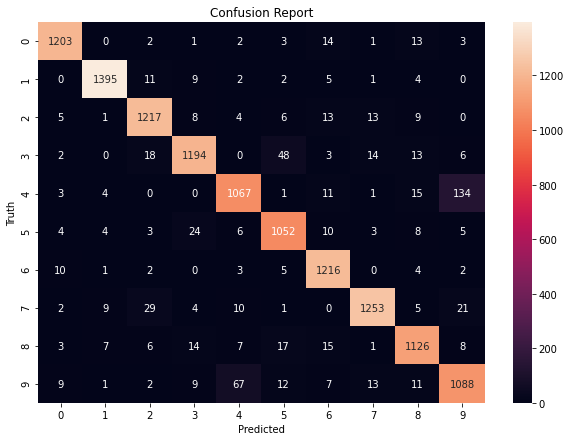

In [19]:
best_features = SelectKBest(score_func=chi2, k=200)
fit = best_features.fit(X_train, y_train)
X_train_new = fit.transform(X_train)
X_test_new = fit.transform(X_test)


perform_classification('Random Forest', X_train_new, X_test_new, y_train, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1242
           1       0.95      0.99      0.97      1429
           2       0.97      0.94      0.96      1276
           3       0.94      0.92      0.93      1298
           4       0.90      0.81      0.85      1236
           5       0.93      0.91      0.92      1119
           6       0.97      0.97      0.97      1243
           7       0.94      0.96      0.95      1334
           8       0.97      0.91      0.94      1204
           9       0.81      0.91      0.85      1219

    accuracy                           0.93     12600
   macro avg       0.93      0.93      0.93     12600
weighted avg       0.93      0.93      0.93     12600

Confusion Report
[[1224    0    1    0    2    1    9    1    2    2]
 [   0 1415    2    3    1    0    3    3    1    1]
 [  10   10 1203    4    3    2    0   35    8    1]
 [   2    5   12 1200    2   47    0   19  

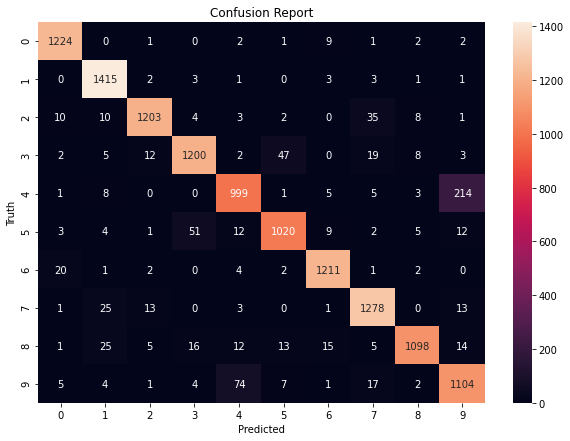

In [20]:
perform_classification('kNN', X_train_new, X_test_new, y_train, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1242
           1       0.98      0.98      0.98      1429
           2       0.96      0.97      0.96      1276
           3       0.97      0.95      0.96      1298
           4       0.94      0.90      0.92      1236
           5       0.95      0.96      0.95      1119
           6       0.96      0.98      0.97      1243
           7       0.97      0.95      0.96      1334
           8       0.96      0.96      0.96      1204
           9       0.90      0.93      0.91      1219

    accuracy                           0.96     12600
   macro avg       0.96      0.96      0.96     12600
weighted avg       0.96      0.96      0.96     12600

Confusion Report
[[1212    0    2    1    2    1   14    1    7    2]
 [   0 1405    5    4    2    3    4    2    4    0]
 [   6    1 1238    2    1    1    5   14    7    1]
 [   0    2   12 1229    1   30    1   10  

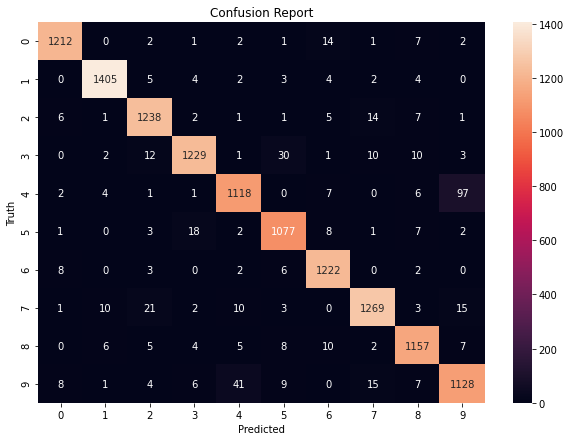

In [21]:
perform_classification('SVM rbf', X_train_new, X_test_new, y_train, y_test)

d:\pycharmprojects\machine_learning_master_2020\venv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1242
           1       0.95      0.97      0.96      1429
           2       0.91      0.86      0.88      1276
           3       0.90      0.86      0.88      1298
           4       0.85      0.83      0.84      1236
           5       0.85      0.83      0.84      1119
           6       0.87      0.93      0.90      1243
           7       0.92      0.90      0.91      1334
           8       0.85      0.85      0.85      1204
           9       0.80      0.84      0.82      1219

    accuracy                           0.88     12600
   macro avg       0.88      0.88      0.88     12600
weighted avg       0.89      0.88      0.88     12600

Confusion Report
[[1190    0    3    1    1    6   27    2   11    1]
 [   0 1386    7   10    3    4    6    1   12    0]
 [  13   14 1099   24   20    6   44   16   29   11]
 [   7   11   28 1121    1   67   10   14  

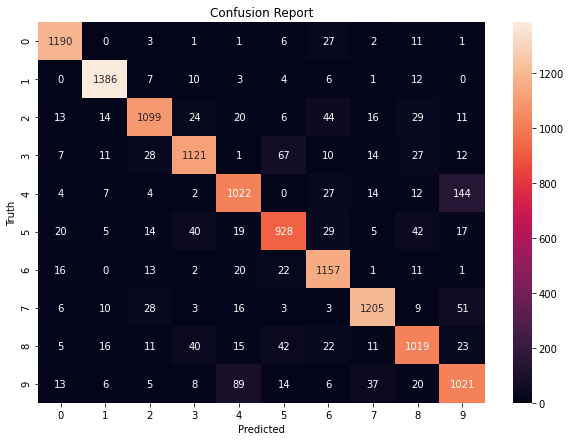

In [22]:
perform_classification('Logistic Regression', X_train_new, X_test_new, y_train, y_test)

